In [59]:
import torch
import os
import matplotlib.pyplot as plt
from data._utils import load_Flavell2023, load_Uzel2022
from train._utils import model_predict, make_predictions
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot
from models._utils import *

In [95]:
PATH = "../logs/hydra/2023_04_04_23_47_22/0/checkpoints/199_epochs_5970_worms.pt"
checkpoint = torch.load(PATH)
for key in checkpoint.keys():
    print(key)

epoch
loss
dataset_name
model_name
optimizer_name
learning_rate
timestamp
covered_neurons
input_size
hidden_size
num_layers
num_cohorts
num_worms
model_state_dict
optimizer_state_dict


In [96]:
# get checkpoint variables
model_name = checkpoint["model_name"]
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
model_state_dict = checkpoint["model_state_dict"]
optimizer_state_dict = checkpoint["optimizer_state_dict"]
num_layers = checkpoint["num_layers"]
smooth_data = True #checkpoint["smooth_data"]
epoch = checkpoint["epoch"]

In [97]:
# load model checkpoint
model = eval(model_name)(input_size, hidden_size, num_layers)
model.load_state_dict(model_state_dict)
model.eval()
print(model)

# load optimizer checkpoint
optimizer = torch.optim.SGD(model.parameters(), lr=0.0) # turn off learning
optimizer.load_state_dict(optimizer_state_dict)
print(optimizer)

NetworkLSTM(
  (lstm): LSTM(302, 128, batch_first=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=128, out_features=302, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [99]:
dataset = load_Flavell2023() # dataset of multiple worms
# dataset = load_Uzel2022() # dataset of multiple worms
for key in dataset["worm0"].keys():
    print(key)
named_neurons_mask = dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = dataset["worm0"]["calcium_data"]
time_in_seconds = dataset["worm0"]["time_in_seconds"]
max_time = dataset["worm0"]["max_time"]

dataset
worm
calcium_data
smooth_calcium_data
residual_calcium
smooth_residual_calcium
neuron_to_idx
idx_to_neuron
max_time
time_in_seconds
dt
num_neurons
num_named_neurons
num_unknown_neurons
named_neurons_mask
unknown_neurons_mask
neurons_mask
named_neuron_to_idx
idx_to_named_neuron
unknown_neuron_to_idx
idx_to_unknown_neuron
slot_to_named_neuron
named_neuron_to_slot
slot_to_unknown_neuron
unknown_neuron_to_slot
slot_to_neuron
neuron_to_slot


In [100]:
named_neuron_inds = torch.where(named_neurons_mask)[0]
print(named_neuron_inds)
nidx = named_neuron_inds[0].item() # pick a neuron to plot
print(nidx)

tensor([ 12,  13,  20,  39,  43,  44,  51,  54,  57,  59,  60,  64,  66,  70,
         73,  74,  76,  84,  85,  87, 113, 117, 118, 119, 120, 121, 125, 126,
        127, 128, 131, 133, 134, 135, 136, 139, 142, 143, 144, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 187, 188, 193, 205, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 218, 224, 225, 240, 241, 242, 244,
        245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257])
12


In [111]:
tau_out = 1
targets, predictions = model_predict(model, calcium_data[:max_time//2, :] * named_neurons_mask, tau=tau_out)
print(targets.shape, predictions.shape)

torch.Size([800, 302]) torch.Size([800, 302])


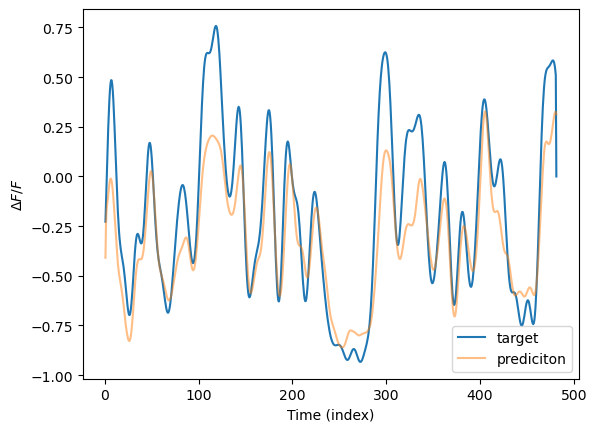

In [112]:
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], targets[:, nidx], label="target")
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], predictions[:, nidx], label="prediciton", alpha=0.5)
plt.legend()
plt.xlabel("Time (index)")
plt.ylabel("$\Delta F / F$")
plt.show()

In [113]:
make_predictions(model, dataset, log_dir=os.getcwd(), tau=1, smooth_data=True)

In [114]:
plot_targets_predictions(log_dir=os.getcwd(), worm="all", neuron="AVAL")

In [115]:
plot_correlation_scatterplot(log_dir=os.getcwd(), worm="all", neuron="AVAL")